In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

2025-10-16 17:11:50.757850: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 17:11:50.801948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 17:11:52.289532: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:
animes_df = pd.read_csv("data/animes.csv")
ratings_df = pd.read_csv("data/reviews.csv")
profiles_df = pd.read_csv("data/profiles.csv")

In [3]:
profiles_df = profiles_df.drop_duplicates(subset="profile", keep="first").reset_index(drop=True)
ratings_df = ratings_df.drop_duplicates().reset_index(drop=True)
animes_df = animes_df.drop_duplicates(subset="uid", keep="first").reset_index(drop=True)

In [4]:
# Extract start year from aired
animes_df["year"] = animes_df["aired"].str.extract(r'(\d{4})').astype(float)

# Convert stringified lists to actual lists
import ast
animes_df['genre'] = animes_df['genre'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# One-hot encode genres
genre_dummies = animes_df["genre"].str.join('|').str.get_dummies()

# Select numeric features
num_features = animes_df[["year", "score"]].fillna(0)

# Normalize numeric features
scaler = MinMaxScaler()
num_features = pd.DataFrame(
    scaler.fit_transform(num_features),
    columns=num_features.columns,
    index=animes_df.index
)

# Combine everything
item_train = pd.concat([num_features, genre_dummies], axis=1)
print(item_train.head())

       year     score  Action  Adventure  Cars  Comedy  Dementia  Demons  \
0  0.997031  0.955580       0          0     0       1         0       0   
1  0.996536  0.956663       0          0     0       0         0       0   
2  0.998021  0.956663       0          1     0       0         0       0   
3  0.994062  1.000000       1          1     0       1         0       0   
4  0.998021  0.956663       1          0     0       0         0       0   

   Drama  Ecchi  ...  Shounen Ai  Slice of Life  Space  Sports  Super Power  \
0      1      0  ...           0              0      0       1            0   
1      1      0  ...           0              0      0       0            0   
2      1      0  ...           0              0      0       0            0   
3      1      0  ...           0              0      0       0            0   
4      0      0  ...           0              0      0       0            0   

   Supernatural  Thriller  Vampire  Yaoi  Yuri  
0             0    

In [5]:
## --- User features ---
import ast

# Convert stringified lists to real lists of ints
def parse_favorites(x):
    try:
        return [int(a) for a in ast.literal_eval(x)]
    except:
        return []  # fallback for malformed entries

profiles_df["favorites_anime"] = profiles_df["favorites_anime"].apply(parse_favorites)
# Step 2: Build user_train
user_features = []
# Create a mapping from anime UID to row index in item_train
anime_id_to_idx = {uid: idx for idx, uid in enumerate(animes_df["uid"])}

for _, row in profiles_df.iterrows():
    favs = row["favorites_anime"]
    
    # Get indices of these anime in item_train
    indices = [anime_id_to_idx[uid] for uid in favs if uid in anime_id_to_idx]
    
    if indices:
        # Average features of the anime to get user preference vector
        user_vec = item_train.iloc[indices].mean(axis=0)
    else:
        # If no valid favorites, use zero vector
        user_vec = np.zeros(item_train.shape[1])
    
    user_features.append(user_vec)

# Create user_train DataFrame
user_train = pd.DataFrame(user_features, index=profiles_df["profile"])
print(user_train.iloc[0].to_dict())

{'year': 0.9946066303809996, 'score': 0.8813109425785483, 'Action': 0.4, 'Adventure': 0.4, 'Cars': 0.0, 'Comedy': 0.45, 'Dementia': 0.0, 'Demons': 0.05, 'Drama': 0.45, 'Ecchi': 0.0, 'Fantasy': 0.25, 'Game': 0.05, 'Harem': 0.05, 'Hentai': 0.0, 'Historical': 0.1, 'Horror': 0.1, 'Josei': 0.05, 'Kids': 0.0, 'Magic': 0.0, 'Martial Arts': 0.05, 'Mecha': 0.05, 'Military': 0.05, 'Music': 0.1, 'Mystery': 0.25, 'Parody': 0.0, 'Police': 0.05, 'Psychological': 0.15, 'Romance': 0.45, 'Samurai': 0.0, 'School': 0.1, 'Sci-Fi': 0.1, 'Seinen': 0.15, 'Shoujo': 0.05, 'Shoujo Ai': 0.0, 'Shounen': 0.3, 'Shounen Ai': 0.0, 'Slice of Life': 0.3, 'Space': 0.0, 'Sports': 0.0, 'Super Power': 0.15, 'Supernatural': 0.4, 'Thriller': 0.0, 'Vampire': 0.05, 'Yaoi': 0.0, 'Yuri': 0.0}


In [6]:
user_train = user_train.fillna(0)
print(item_train.isna().sum().sum())   # total NaNs in item_train
print(user_train.isna().sum().sum())   # total NaNs in user_train

0
0


In [7]:
anime_to_idx = {uid: i for i, uid in enumerate(animes_df["uid"])}
user_to_idx  = {name: i for i, name in enumerate(profiles_df["profile"])}
idx_to_anime = {i:uid for i, uid in enumerate(animes_df["uid"])}
idx_to_user  = {i:name for i, name in enumerate(profiles_df["profile"])}

In [8]:
# Create new columns for index lookups
ratings_df["user_idx"] = ratings_df["profile"].map(user_to_idx)
ratings_df["anime_idx"] = ratings_df["anime_uid"].map(anime_to_idx)


In [9]:
# Drop any rows where a mapping failed
ratings_df = ratings_df.dropna(subset=["user_idx", "anime_idx", "score"]).reset_index(drop=True)

# Convert to integer indices
ratings_df["user_idx"] = ratings_df["user_idx"].astype(int)
ratings_df["anime_idx"] = ratings_df["anime_idx"].astype(int)

In [10]:
user_matrix = user_train.to_numpy()
item_matrix = item_train.to_numpy()

u_train = user_matrix[ratings_df["user_idx"].values]
i_train = item_matrix[ratings_df["anime_idx"].values]

# Extract target scores
y_train = ratings_df["score"].values

In [11]:
print("Shapes:")
print("u_train:", u_train.shape)
print("i_train:", i_train.shape)
print("y_train:", y_train.shape)


Shapes:
u_train: (130519, 45)
i_train: (130519, 45)
y_train: (130519,)


In [12]:
# pick a random index
idx = np.random.randint(0, len(y_train))

print("Review index:", idx)
print("Profile:", ratings_df.iloc[idx]["profile"])
print("Anime UID:", ratings_df.iloc[idx]["anime_uid"])
print("Score (y_train):", y_train[idx])

# Compare with original matrices
user_idx = ratings_df.iloc[idx]["user_idx"]
anime_idx = ratings_df.iloc[idx]["anime_idx"]

print("u_train[idx] equals user_matrix[user_idx]?:", np.allclose(u_train[idx], user_matrix[user_idx]))
print("i_train[idx] equals item_matrix[anime_idx]?:", np.allclose(i_train[idx], item_matrix[anime_idx]))

Review index: 7106
Profile: kirala
Anime UID: 12113
Score (y_train): 7
u_train[idx] equals user_matrix[user_idx]?: True
i_train[idx] equals item_matrix[anime_idx]?: True


In [13]:
from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
(u_train_train, u_train_test,
 i_train_train, i_train_test,
 y_train_train, y_train_test) = train_test_split(
    u_train, i_train, y_train,
    test_size=0.2,   # 20% test
    random_state=42, # for reproducibility
    shuffle=True     # shuffle before splitting
)


In [14]:
from keras import layers, Model, Input
import tensorflow as tf

user_dim = u_train.shape[1]
item_dim = i_train.shape[1]
embedding_dim = 32  # size of the learned embedding

# --- User tower ---
user_input = Input(shape=(user_dim,), name="user_input")
user_emb = layers.Dense(64, activation="relu")(user_input)
user_emb = layers.Dense(embedding_dim, activation="relu")(user_emb)

# --- Item tower ---
item_input = Input(shape=(item_dim,), name="item_input")
item_emb = layers.Dense(64, activation="relu")(item_input)
item_emb = layers.Dense(embedding_dim, activation="relu")(item_emb)

# --- Interaction ---
# dot product between embeddings to get a single score
dot = layers.Dot(axes=1)([user_emb, item_emb])

# optional: scale output to [0, 10] since y_train ranges 0–10
output = layers.Activation("linear")(dot)

# --- Build model ---
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

model.summary()


E0000 00:00:1760649150.224698   21397 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1760649150.233609   21397 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 45)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,944 │ user_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      2,944 │ item_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ dot[0][0]         │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,048 (39.25 KB)

 Trainable params: 10,048 (39.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history = model.fit(
    [u_train_train, i_train_train],  # train inputs
    y_train_train,                   # train labels
    batch_size=512,
    epochs=10,
    shuffle=True,
    validation_data=([u_train_test, i_train_test], y_train_test)  # test/validation set
)



Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 10.3628 - mae: 2.4498 - val_loss: 4.8061 - val_mae: 1.7266
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5406 - mae: 1.6860 - val_loss: 4.4951 - val_mae: 1.6777
Epoch 3/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3248 - mae: 1.6359 - val_loss: 4.3516 - val_mae: 1.6298
Epoch 4/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2003 - mae: 1.6034 - val_loss: 4.2811 - val_mae: 1.6410
Epoch 5/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1296 - mae: 1.5852 - val_loss: 4.2310 - val_mae: 1.6143
Epoch 6/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0858 - mae: 1.5728 - val_loss: 4.2143 - val_mae: 1.5882
Epoch 7/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0581 - mae: 1.5659 - val_loss: 4.1796 - val_mae: 1.5832
Epoch 8/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0273 - mae: 1.5579 - val_loss: 4.2327 - val_mae: 1.5641
Epoch 9/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

In [16]:
# pick the first 10 examples from the validation set
num_samples = 10
u_sample = u_train_test[:num_samples]
i_sample = i_train_test[:num_samples]
y_actual = y_train_test[:num_samples]

# get predictions
y_pred = model.predict([u_sample, i_sample]).flatten()

df_compare = pd.DataFrame({
    "Actual Score": y_actual,
    "Predicted Score": y_pred
})

print(df_compare)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
   Actual Score  Predicted Score
0             9         6.523465
1             8         6.158461
2             9         7.675061
3             4         5.913553
4             6         6.099283
5             3         4.208059
6            10         9.009647
7             7         7.034719
8             8         7.811982
9             5         5.031000


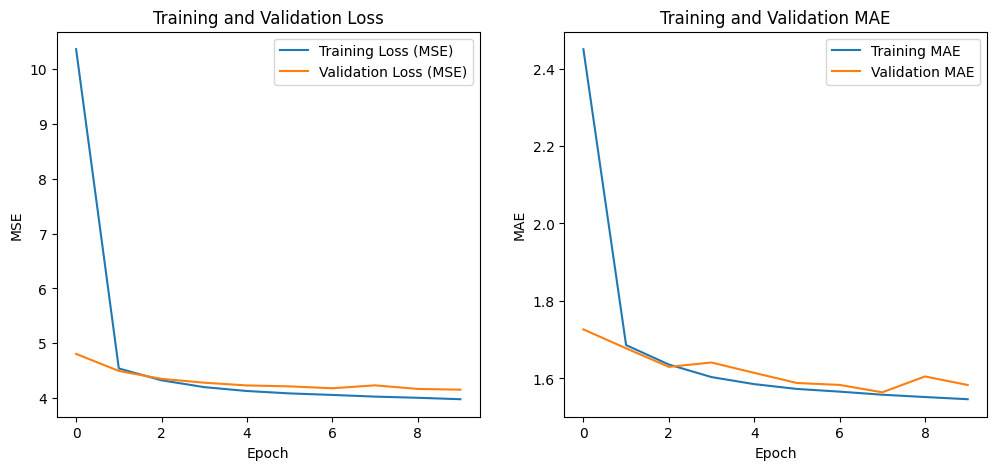

In [17]:
import matplotlib.pyplot as plt

# Assuming you stored the history when fitting the model
# --- Plot training & validation loss ---
plt.figure(figsize=(12,5))

# Loss (MSE)
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Training and Validation Loss')
plt.legend()

# MAE
plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.show()


In [18]:
from save_and_load_recommender import save_recommender, load_recommender
save_recommender(
    model,
    save_dir="saved_recommender",
    user_matrix=user_matrix,
    item_matrix=item_matrix,
    user_to_idx=user_to_idx,
    anime_to_idx=anime_to_idx,
    idx_to_user=idx_to_user,
    idx_to_anime=idx_to_anime
)


✅ Model and data saved in: saved_recommender


In [19]:
# Assuming load_recommender is defined as above
model, user_matrix, item_matrix, anime_to_idx, user_to_idx, idx_to_anime, idx_to_user = load_recommender("saved_recommender")

✅ Model and data loaded from: saved_recommender


In [20]:
print("user_train shape:", user_matrix.shape)
print("item_train shape:", item_matrix.shape)
print("Number of entries in anime_to_idx:", len(anime_to_idx))
print("Number of entries in idx_to_anime:", len(idx_to_anime))
print("Check first mapping:", list(anime_to_idx.items())[:5])
print("Check first reverse mapping:", list(idx_to_anime.items())[:5])


user_train shape: (47885, 45)
item_train shape: (16216, 45)
Number of entries in anime_to_idx: 16216
Number of entries in idx_to_anime: 16216
Check first mapping: [(28891, 0), (23273, 1), (34599, 2), (5114, 3), (31758, 4)]
Check first reverse mapping: [(0, 28891), (1, 23273), (2, 34599), (3, 5114), (4, 31758)]


In [21]:
# Example: pick first user and first anime
user_vec = user_matrix[user_to_idx[idx_to_user[0]]]  # or just user_train[0]
item_vec = item_matrix[anime_to_idx[idx_to_anime[0]]]  # or item_train[0]

user_vec = user_vec.reshape(1, -1)
item_vec = item_vec.reshape(1, -1)

pred_score = model.predict([user_vec, item_vec])
print("Predicted score for first user & first anime:", pred_score[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted score for first user & first anime: 8.907264
